# Bitcoin USD - Time Series Forecasting

# <font color='blue'>0. Identification for Business Requirements</font> <a class="anchor" id="first-bullet"></a>

### A Short Description About the Dataset & It's Source


####  Dataset of Bitcoin Historical Data
The dataset is a mix of CSV files for select bitcoin exchanges for the time period of Jan 2012 to December March 2021, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price. 

Source of Datasets:

Created by Zielak,
Neuroscience Ph.D. - Data Scientist <br>
https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

## <font color= blue >1. Importing the Necessary Libraries</font> <a class="anchor" id="second-bullet"></a>

In [1]:
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#########BASIC
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

######## GRAPHICAL
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc
import matplotlib.pyplot as plt

######## STATISTICAL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import matplotlib.pyplot as plt

######### RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

######## FB PROPHET
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

########ARIMAX
import pmdarima as pm

######### WARNINGS
import warnings
warnings.filterwarnings('ignore')

C:\Users\migue\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



## <font color= blue >2. Loading the dataset </font> <a class="anchor" id="third-bullet"></a>

In [4]:
import datetime, pytz
# conversion function for the native timestamps in the csv file
def conversion (time):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time)))

data = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv", parse_dates=[0], date_parser=conversion)

# -------------------------------------------------------------------------------------

## <font color= blue >3. Exploratory Data Analysis </font> <a class="anchor" id="fourth-bullet"></a>

#### Data Exploration

In this section we will explore the Historic Bitcoin Prices and try to find some insights. We will be using the Coinbase dataset as it is one of the mostly used Bitcoin Exchange/Wallet in the world.

In [5]:
## Grouping the time from minutes to Hours
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81067 entries, 2011-12-31 08:00:00 to 2021-03-31 02:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               77526 non-null  float64
 1   High               77526 non-null  float64
 2   Low                77526 non-null  float64
 3   Close              77526 non-null  float64
 4   Volume_(BTC)       77526 non-null  float64
 5   Volume_(Currency)  77526 non-null  float64
 6   Weighted_Price     77526 non-null  float64
dtypes: float64(7)
memory usage: 4.9 MB


In [7]:
data.describe()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,77526.000000,77526.000000,77526.000000,77526.000000,7.752600e+04,7.752600e+04,77526.000000
mean,4794.283000,4798.627194,4790.124749,4794.599105,1.004044e+01,3.993241e+04,4794.421360
std,8278.419963,8287.885711,8270.260340,8279.824083,3.109664e+01,1.526329e+05,8279.087532
min,3.800000,3.800000,3.800000,3.800000,6.000000e-08,6.480000e-07,3.800000
25%,286.852500,287.000000,286.657500,286.860000,4.918841e-01,1.925644e+02,286.870010
50%,788.640000,789.025000,787.995000,788.785000,2.283895e+00,2.041196e+03,788.766055
75%,7422.015000,7427.270000,7419.282500,7421.607500,8.377132e+00,2.084335e+04,7421.980093
max,61601.930000,61620.390000,61564.410000,61620.390000,2.258823e+03,6.553495e+06,61591.472734


In [8]:
display(data.head(5))
display(data.tail(5))

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 08:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2021-03-30 22:00:00,59118.91,59135.00,59023.96,59037.79,2.684344,158619.612840,59090.651748
2021-03-30 23:00:00,58644.04,58670.91,58591.06,58591.06,9.979587,585005.680240,58620.228970
2021-03-31 00:00:00,58758.44,58762.56,58758.44,58762.56,0.573484,33699.187441,58762.179612
2021-03-31 01:00:00,58699.43,58699.43,58643.16,58657.09,0.281702,16521.438155,58648.607194
2021-03-31 02:00:00,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


#### Missing Values

In this section we will explore any Missing Values present in the dataframe.

In [9]:
# Number of NaNs on each columns 
data.isna().sum()

Open                 3541
High                 3541
Low                  3541
Close                3541
Volume_(BTC)         3541
Volume_(Currency)    3541
Weighted_Price       3541
dtype: int64

In [10]:
# Function to check wheter or not a particular datasets has missing values
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns


missing_values_table(data)

Your selected dataframe has 7 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
Open,3541,4.4
High,3541,4.4
Low,3541,4.4
Close,3541,4.4
Volume_(BTC),3541,4.4
Volume_(Currency),3541,4.4
Weighted_Price,3541,4.4


In [11]:
missing_values_table(data)

Your selected dataframe has 7 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
Open,3541,4.4
High,3541,4.4
Low,3541,4.4
Close,3541,4.4
Volume_(BTC),3541,4.4
Volume_(Currency),3541,4.4
Weighted_Price,3541,4.4


In [12]:
# Displaying all Dates with missing values information

nan_rows  = data[data.isna().any(axis=1)]
nan_rows.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__Interpolation__
Unfortunately, time series, or at least the ones that are worthy of interest, are usually non-stationary. This means that their statistical characteristics — average, variance, and standard deviation — do change with time.

In [13]:
# Since we are working with time series and we have dates as index
# We decided that --Interpolation, would be the best usage -- When we use neighboring data points to estimate the missing value. 
# Interpolation can also be a form of imputation.

    
data['Volume_(BTC)']=data['Volume_(BTC)'].interpolate( method='polynomial', axis=0,order=2)
data['Volume_(Currency)']=data['Volume_(Currency)'].interpolate( method='polynomial', axis=0, order=2)
data['Weighted_Price']=data['Weighted_Price'].interpolate( method='time', axis=0)


data['Open']=data['Open'].interpolate( method='time', axis=0)
data['High']=data['High'].interpolate( method='time', axis=0)
data['Low']=data['Low'].interpolate( method='time', axis=0)
data['Close']=data['Close'].interpolate( method='time', axis=0)

In [14]:
missing_values_table(data)

Your selected dataframe has 7 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


#### Downsampling Data - decreasing the timestamp frequency

Here we decided to downsample the data into days, months, quarters and years for visualization and further analysis.


In [15]:
# Default resampling is set to per Hour. 
# Here we decided to downsample the data into days, months, quarters and years for visualization and further analysis.
df = data.copy()

# Resampling to daily frequency
df_day = df.resample('D').mean()

# Resampling to monthly frequency
df_week = df.resample('W').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to quarterly frequency
df_quarter = df.resample('Q-DEC').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

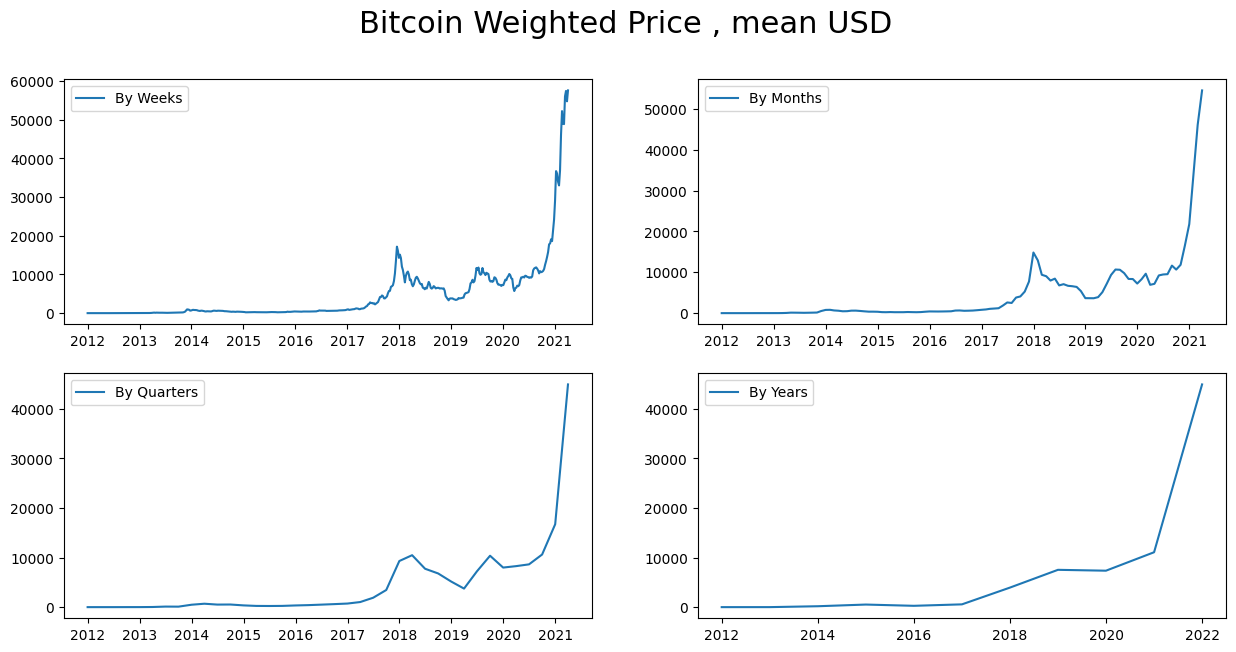

In [16]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin Weighted Price , mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df_week.Weighted_Price, '-', label='By Weeks')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_quarter.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

plt.show()

# -------------------------------------------------------------------------------------

## <font color= blue >4. Data Visualization </font> <a class="anchor" id="fourth-bullet"></a>

In [17]:
# basically creating a range that includes all data
start = '2012-01-01'
end = '2021-01-01'

# find rows between start and end time 
data_monthly = df_month[(df_month.index >= start) & (df_month.index <= end)].reset_index()
data_monthly.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2012-01-31,6.174209,6.176319,6.173042,6.175152,2.985624,17.497592,6.174415
1,2012-02-29,5.229638,5.230745,5.228178,5.229284,8.999805,46.343317,5.229631
2,2012-03-31,4.957446,4.958320,4.953548,4.954442,18.106701,89.086093,4.955580
3,2012-04-30,4.978567,4.980109,4.977019,4.978449,13.234024,66.125113,4.978601
4,2012-05-31,5.042563,5.042865,5.041864,5.042133,21.598497,109.087294,5.042425


### Visualize Bitcoin Prices from 2012-2021

In [18]:
# We use Plotly to create the plots https://plot.ly/python/
trace1 = go.Scatter(
    x = data_monthly['Timestamp'],
    y = data_monthly['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = data_monthly['Timestamp'],
    y = data_monthly['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = data_monthly['Timestamp'],
    y = data_monthly['Weighted_Price'].astype(float),
    mode = 'lines',
    name = 'Weighted Avg'
)

layout = dict(
    title='Historical Bitcoin Prices (2012-2018) with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([

                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

_ = [trace1,trace2, trace3]
fig = dict(data=_, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

### Visualizing Bitcoin Market Volume from 2012-2021

In [19]:
trace1 = go.Scatter(
    x = data_monthly['Timestamp'],
    y = data_monthly['Volume_(Currency)'].astype(float),
    mode = 'lines',
    name = 'Bitcoin Price (Open)'
)

layout = dict(
    title='Historical Bitcoin Volume (USD) (2012-2021) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

_= [trace1]
fig = dict(data=_, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

# -------------------------------------------------------------------------------------

#### Selecting the range for our analysis: 2012 -- 2021

There are an incredible amount of challenges in correctly forecasting a time-series analysis for Crypto.
Too many factors drive the price volatility (that historical data in unable to capture). Due to this we decided to range our dataset to exclude the year of 2021 forward, removing the steep upward trend in price

In [20]:
# basically creating a range that includes all data
start = '2012-01-01'
end = '2021-01-01'

# find rows between start and end time 
df_day = df_day[(df_day.index >= start) & (df_day.index <= end)]
df_week = df_week[(df_week.index >= start) & (df_week.index <= end)]
df_month = df_month[(df_month.index >= start) & (df_month.index <= end)]
df_quarter = df_quarter[(df_quarter.index >= start) & (df_quarter.index <= end)]
df_year = df_year[(df_year.index >= start) & (df_year.index <= end)]

# -------------------------------------------------------------------------------------

## <font color= blue >5. Checking stationary vs Non-stationary Data </font> <a class="anchor" id="fifth-bullet"></a>

### ACF and PACF

In [21]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'PACF for Weighted Price -- Daily')

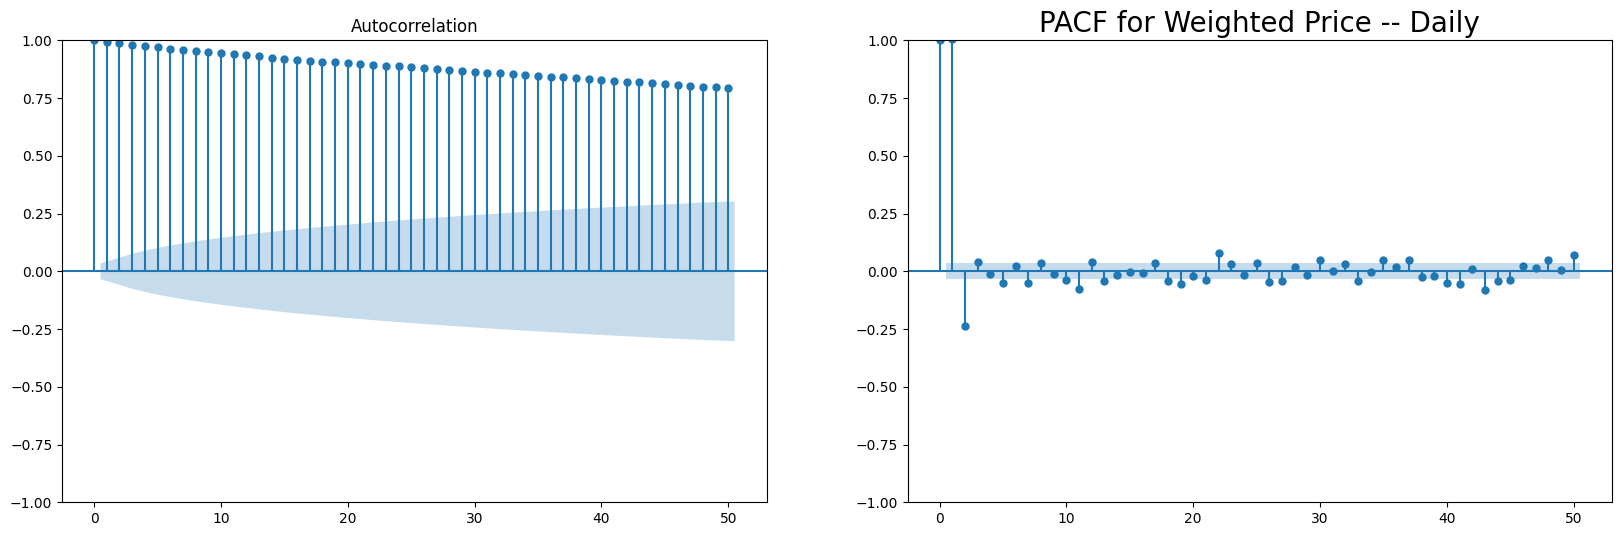

In [22]:
# For daily Frequency ACF and PACF

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

plot_acf(df_day.Weighted_Price, lags=50, alpha=0.05, ax=ax1)
plt.title("ACF for Weighted Price", size=20)

plot_pacf(df_day.Weighted_Price, lags=50, alpha=0.05, method='ols', ax=ax2)
plt.title("PACF for Weighted Price -- Daily", size=20)

Figure 1 - presents the time series, ACF and PACF plots for the usd prices of the Bitcoin. <br>

### ACF and PACF

Trough visual inspection Figure 1 it is clear that the data values do not have a constant mean and variances.We can observe decaying pattern in ACF plot and the highly significant first lag in PACF. <br>

Autocorrelations are declining gradually as the number of lags such a property is common in nonstationary processes. <br> 

### ADF Augmented Dickey–Fuller test

The formal statistical tool for checking stationarity of time series data is to go for Augumented Dickey Fuller (ADF) test.

__H0: The time series is non-stationary.__<br>
__HA: The time series is stationary.__

If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [23]:
## Augmented Dickey–Fuller test

    # "HO: Non-stationary"
    # "H1: Stationary"

from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
series = df_day.Weighted_Price
X = series.values

In [24]:
# Stability Test (Dickey-Fuller Test)
def is_stationary(y):
    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

In [25]:
is_stationary(X)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [26]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.061647
p-value: 0.998748
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


#### Time Series Components

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

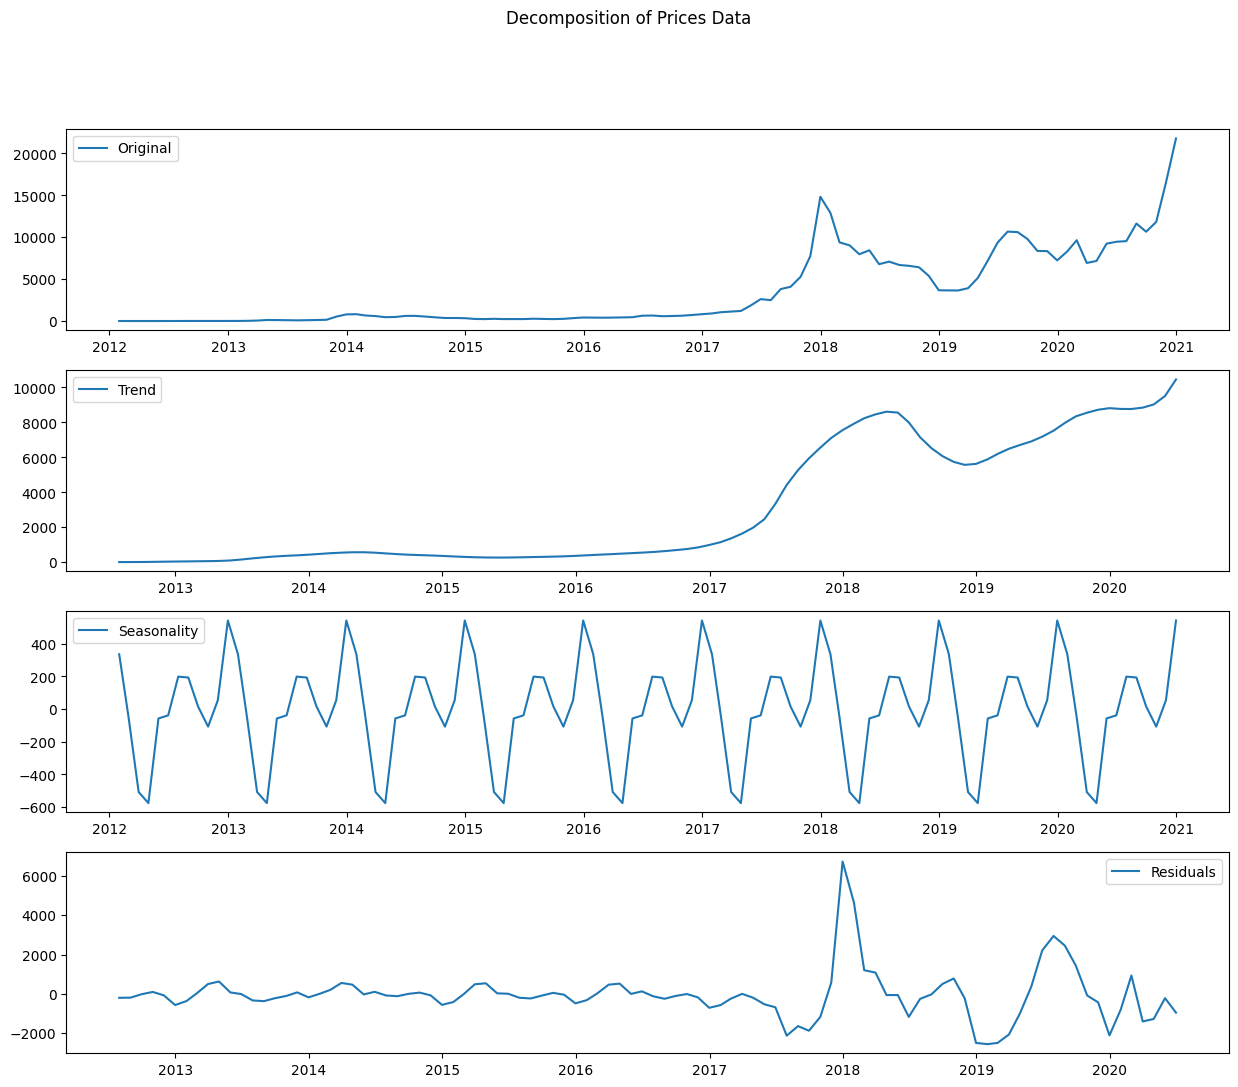

In [28]:
decomposition = sm.tsa.seasonal_decompose(df_month.Weighted_Price)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(15,12))

plt.subplot(411)
plt.plot(df_month.Weighted_Price, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

Post time series decomposition we don't observe any seasonality. Also, there is no constant mean, variance and covariance, hence the series is Non Stationary. 

# -------------------------------------------------------------------------------------

## <font color= blue >6. Normalizing Time Series Data </font> <a class="anchor" id="fifth-bullet"></a>

In [29]:
df_day.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2012-01-01,4.747500,4.747500,4.747500,4.747500,3.912366,19.604574,4.747500
2012-01-02,5.002667,5.002667,5.002667,5.002667,14.035180,69.592551,5.002667
2012-01-03,5.205212,5.205212,5.205212,5.205212,9.853269,51.408023,5.205212
2012-01-04,5.181548,5.216340,5.181548,5.216340,16.580542,89.792815,5.194110
2012-01-05,6.119948,6.127240,6.119948,6.127240,4.859769,27.799823,6.123903


In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
data_normalized =pd.DataFrame(scaler.fit_transform(df_day), columns=df_day.columns) 

In [31]:
temp=df_day.reset_index()

In [32]:
data_normalized['Timestamp']=temp['Timestamp']

In [33]:
data_normalized=data_normalized.set_index(data_normalized.Timestamp)
data_normalized=data_normalized.drop(columns=['Timestamp'])

In [34]:
data_normalized

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2012-01-01,-0.765935,-0.765870,-0.765996,-0.765927,-0.125709,-0.557349,-0.765928
2012-01-02,-0.765879,-0.765814,-0.765941,-0.765871,0.027668,-0.556431,-0.765872
2012-01-03,-0.765835,-0.765769,-0.765896,-0.765826,-0.035695,-0.556765,-0.765827
2012-01-04,-0.765840,-0.765767,-0.765901,-0.765824,0.066234,-0.556060,-0.765830
2012-01-05,-0.765635,-0.765568,-0.765696,-0.765625,-0.111354,-0.557199,-0.765626
...,...,...,...,...,...,...,...
2020-12-28,5.124018,5.127498,5.125390,5.126787,-0.085477,2.702019,5.126163
2020-12-29,5.073853,5.073732,5.074599,5.074042,-0.065834,3.288783,5.073933
2020-12-30,5.372026,5.374215,5.371875,5.374104,0.018742,6.415360,5.373557


In [35]:
# split data into train and test sets
splitter= '2019-01-01'
data_train = data_normalized.loc[data_normalized.index <= splitter]
data_test = data_normalized.loc[data_normalized.index > splitter]

In [36]:
X_train, y_train = data_train.iloc[:, :-1], data_train.iloc[:, -1]
X_test, y_test = data_test.iloc[:, :-1], data_test.iloc[:, -1]

In [37]:
y_train= y_train.to_numpy()
y_test= y_test.to_numpy()
X_train= X_train.to_numpy()
X_test= X_test.to_numpy()

In [38]:
# reshaping to  3D [samples, timesteps, features]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2558, 1, 6) (2558,) (731, 1, 6) (731,)


In [39]:
X_test

array([[[ 0.06851384,  0.06847635,  0.06901024,  0.06893962,
         -0.11164233, -0.21548954]],

       [[ 0.07320251,  0.07277401,  0.07359733,  0.07330269,
         -0.15615717, -0.42303854]],

       [[ 0.06125371,  0.06110086,  0.06165447,  0.06139132,
         -0.11211532, -0.22318595]],

       ...,

       [[ 5.37202617,  5.37421466,  5.37187532,  5.37410362,
          0.01874164,  6.41536032]],

       [[ 5.55435917,  5.55444521,  5.55383463,  5.55432395,
         -0.08601737,  2.89792591]],

       [[ 5.63849686,  5.63761742,  5.63761858,  5.63676069,
         -0.07654423,  3.28877275]]])

In [40]:
test = pd.DataFrame(data_test['Weighted_Price'])

In [41]:
train = pd.DataFrame(data_train['Weighted_Price'])

In [42]:
pd.concat([train, test], join='outer')

,Weighted_Price
Timestamp,
2012-01-01,-0.765928
2012-01-02,-0.765872
2012-01-03,-0.765827
2012-01-04,-0.765830
2012-01-05,-0.765626
...,...
2020-12-28,5.126163
2020-12-29,5.073933
2020-12-30,5.373557


In [43]:
test=test.rename(columns={'Weighted_Price': 'Test Set'}) 

In [44]:
train=train.rename(columns={'Weighted_Price': 'Train Set'}) 

In [45]:
whole_data=train.join(test, how='outer' )
whole_data.head()

,Train Set,Test Set
Timestamp,,
2012-01-01,-0.765928,NaN
2012-01-02,-0.765872,NaN
2012-01-03,-0.765827,NaN
2012-01-04,-0.765830,NaN
2012-01-05,-0.765626,NaN


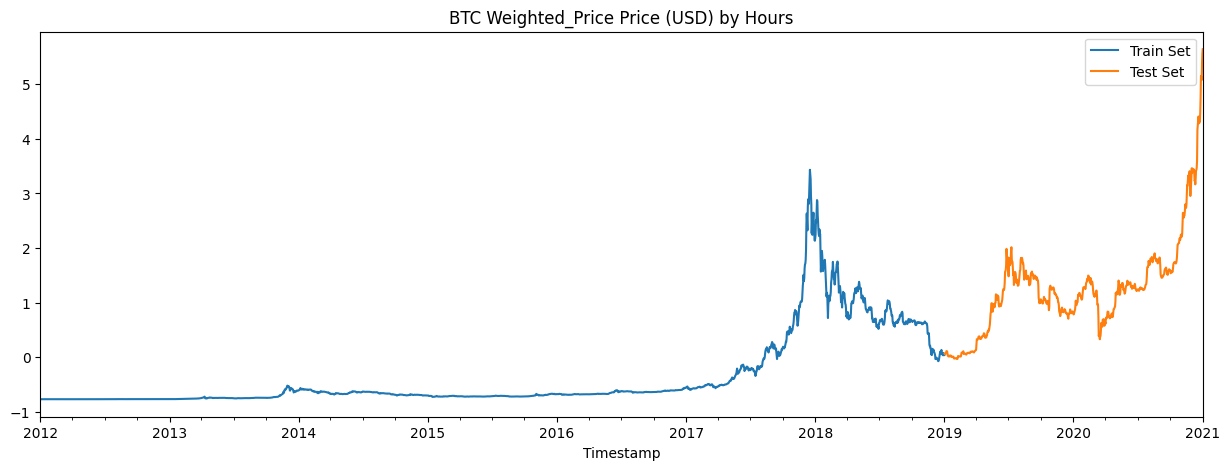

In [46]:
plotting = whole_data.plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

# -------------------------------------------------------------------------------------

## <font color= blue >7. Model Construction </font> <a class="anchor" id="fifth-bullet"></a>

## <font color= blue >7.1 Multivariate Time Series Forecasting with LSTM </font> <a class="anchor" id="fifth-bullet"></a>

In [47]:
model = Sequential()
model.add(LSTM(120,activation="sigmoid",input_shape=(1,6)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2,validation_data=(X_test, y_test), shuffle=False)

Epoch 1/100
52/52 - 5s - loss: 0.3767 - val_loss: 1.7274 - 5s/epoch - 94ms/step
Epoch 2/100
52/52 - 1s - loss: 0.3756 - val_loss: 1.1214 - 1s/epoch - 25ms/step
Epoch 3/100
52/52 - 1s - loss: 0.1752 - val_loss: 0.5353 - 1s/epoch - 23ms/step
Epoch 4/100
52/52 - 1s - loss: 0.0940 - val_loss: 0.2477 - 1s/epoch - 25ms/step
Epoch 5/100
52/52 - 1s - loss: 0.0600 - val_loss: 0.1335 - 1s/epoch - 24ms/step
Epoch 6/100
52/52 - 1s - loss: 0.0507 - val_loss: 0.0926 - 1s/epoch - 23ms/step
Epoch 7/100
52/52 - 1s - loss: 0.0448 - val_loss: 0.0762 - 1s/epoch - 23ms/step
Epoch 8/100
52/52 - 1s - loss: 0.0448 - val_loss: 0.0732 - 1s/epoch - 24ms/step
Epoch 9/100
52/52 - 1s - loss: 0.0420 - val_loss: 0.0709 - 1s/epoch - 25ms/step
Epoch 10/100
52/52 - 1s - loss: 0.0390 - val_loss: 0.0699 - 1s/epoch - 26ms/step
Epoch 11/100
52/52 - 1s - loss: 0.0386 - val_loss: 0.0710 - 1s/epoch - 24ms/step
Epoch 12/100
52/52 - 1s - loss: 0.0382 - val_loss: 0.0663 - 1s/epoch - 23ms/step
Epoch 13/100
52/52 - 1s - loss: 0.037

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120)               60960     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
Total params: 61,081
Trainable params: 61,081
Non-trainable params: 0
_________________________________________________________________


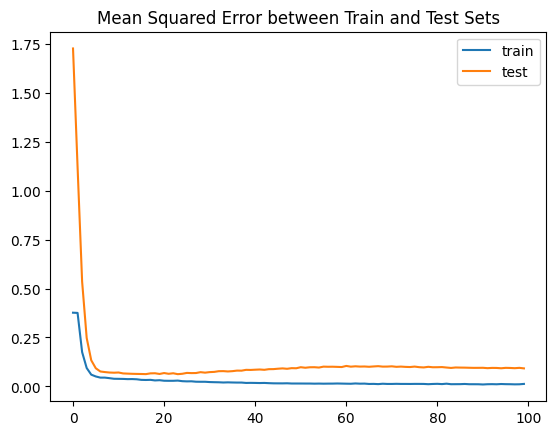

In [49]:
# plot history
import matplotlib.pyplot as pyplot 
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Mean Squared Error between Train and Test Sets')
pyplot.show()

In [50]:
predicted_BTC_price = model.predict(X_test)
predicted_BTC_price

23/23 [==============================] - 0s 6ms/step


array([[ 9.01498944e-02],
       [ 8.93780142e-02],
       [ 8.28095376e-02],
       [ 9.14380401e-02],
       [ 9.52321589e-02],
       [ 1.39904916e-01],
       [ 1.35749400e-01],
       [ 1.33146107e-01],
       [ 9.51486230e-02],
       [ 6.36804402e-02],
       [ 4.71435785e-02],
       [ 4.17984575e-02],
       [ 4.51714247e-02],
       [ 5.40485978e-02],
       [ 4.67519462e-02],
       [ 4.84287143e-02],
       [ 4.41398025e-02],
       [ 5.25190085e-02],
       [ 4.51747775e-02],
       [ 3.08948308e-02],
       [ 3.94652039e-02],
       [ 4.28124219e-02],
       [ 4.12615240e-02],
       [ 3.41906101e-02],
       [ 3.48896086e-02],
       [ 3.21723223e-02],
       [ 1.63888931e-02],
       [ 3.79577279e-04],
       [ 6.56314194e-03],
       [ 6.62811100e-03],
       [ 3.32270563e-03],
       [ 4.70072031e-03],
       [ 7.86125660e-03],
       [ 1.89943612e-03],
       [ 5.31962514e-03],
       [ 6.14866614e-04],
       [-7.66943395e-03],
       [ 2.63827294e-02],
       [ 4.4

In [51]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
print("Shape of X_test: ", X_test.shape)
X_test

Shape of X_test:  (731, 6)


array([[ 0.06851384,  0.06847635,  0.06901024,  0.06893962, -0.11164233,
        -0.21548954],
       [ 0.07320251,  0.07277401,  0.07359733,  0.07330269, -0.15615717,
        -0.42303854],
       [ 0.06125371,  0.06110086,  0.06165447,  0.06139132, -0.11211532,
        -0.22318595],
       ...,
       [ 5.37202617,  5.37421466,  5.37187532,  5.37410362,  0.01874164,
         6.41536032],
       [ 5.55435917,  5.55444521,  5.55383463,  5.55432395, -0.08601737,
         2.89792591],
       [ 5.63849686,  5.63761742,  5.63761858,  5.63676069, -0.07654423,
         3.28877275]])

In [52]:
from numpy import concatenate

Bitcoin_pred = concatenate((predicted_BTC_price, X_test[:,:]), axis=1)

In [53]:
Bitcoin_pred = scaler.inverse_transform(Bitcoin_pred)
Bitcoin_pred = Bitcoin_pred[:,0]
Bitcoin_pred

array([ 3914.74587417,  3911.22046569,  3881.22026039,  3920.62922285,
        3937.95810281,  4141.99200341,  4123.01251087,  4111.12249227,
        3937.57656922,  3793.85192679,  3718.3231127 ,  3693.91033954,
        3709.31569403,  3749.86040971,  3716.53441027,  3724.19271364,
        3704.60396517,  3742.87431598,  3709.33100709,  3644.11020155,
        3683.25366945,  3698.54141957,  3691.45800279,  3659.16301519,
        3662.35555161,  3649.94488871,  3577.85722719,  3504.73787326,
        3532.98007033,  3533.27680355,  3518.1800244 ,  3524.47383135,
        3538.90894986,  3511.67952506,  3527.3005556 ,  3505.81251032,
        3467.97562142,  3623.50207918,  3707.16151972,  3699.11555753,
        3732.24248708,  3694.92440492,  3703.02528998,  3669.68663174,
        3686.1907839 ,  3689.38277585,  3682.37388267,  3903.16327392,
        4009.31699842,  4022.38966225,  4032.85971709,  4019.94943984,
        4067.35767665,  4140.31736633,  3898.60195342,  3898.50401784,
      

In [54]:
data_test=pd.DataFrame(scaler.inverse_transform(data_test), columns=data.columns, index=test.index)
data_test.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2019-01-02,3815.927500,3818.779583,3815.099583,3817.929167,4.840742,18622.726238,3816.618072
2019-01-03,3837.342083,3838.425417,3836.031667,3837.857083,1.902776,7328.448351,3837.468446
2019-01-04,3782.768333,3785.064167,3781.533333,3783.452917,4.809525,18203.907485,3783.228856
2019-01-05,3835.461250,3836.792083,3834.657083,3836.129167,3.316241,12718.473391,3836.008899
2019-01-06,3855.950417,3859.148333,3855.473750,3858.436250,2.775965,10939.781885,3857.625335


In [55]:
data_train=pd.DataFrame(scaler.inverse_transform(data_train), columns=data.columns, index=train.index)
data_train.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2012-01-01,4.747500,4.747500,4.747500,4.747500,3.912366,19.604574,4.747500
2012-01-02,5.002667,5.002667,5.002667,5.002667,14.035180,69.592551,5.002667
2012-01-03,5.205212,5.205212,5.205212,5.205212,9.853269,51.408023,5.205212
2012-01-04,5.181548,5.216340,5.181548,5.216340,16.580542,89.792815,5.194110
2012-01-05,6.119948,6.127240,6.119948,6.127240,4.859769,27.799823,6.123903


In [56]:
data_test['M_LSTM_Pred'] = Bitcoin_pred
mixed_data = pd.concat([data_test, data_train], sort=False)
mixed_data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,M_LSTM_Pred
Timestamp,,,,,,,,
2019-01-02,3815.927500,3818.779583,3815.099583,3817.929167,4.840742,18622.726238,3816.618072,3914.745874
2019-01-03,3837.342083,3838.425417,3836.031667,3837.857083,1.902776,7328.448351,3837.468446,3911.220466
2019-01-04,3782.768333,3785.064167,3781.533333,3783.452917,4.809525,18203.907485,3783.228856,3881.220260
2019-01-05,3835.461250,3836.792083,3834.657083,3836.129167,3.316241,12718.473391,3836.008899,3920.629223
2019-01-06,3855.950417,3859.148333,3855.473750,3858.436250,2.775965,10939.781885,3857.625335,3937.958103


In [57]:
#saving the predicted values in a common data frame for future comparison
final_data = mixed_data
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'M_LSTM_Pred': 'LSTM prediction'})
final_data = final_data[['Timestamp','Weighted_Price','LSTM prediction']]

In [58]:
final_data

,Timestamp,Weighted_Price,LSTM prediction
0,2019-01-02,3816.618072,3914.745874
1,2019-01-03,3837.468446,3911.220466
2,2019-01-04,3783.228856,3881.220260
3,2019-01-05,3836.008899,3920.629223
4,2019-01-06,3857.625335,3937.958103
...,...,...,...
3284,2018-12-28,3683.368969,NaN
3285,2018-12-29,3874.444404,NaN
3286,2018-12-30,3791.141409,NaN
3287,2018-12-31,3768.529517,NaN


<AxesSubplot: title={'center': 'Weighted Price vs Weighted Price M_LSTM'}, xlabel='Timestamp'>

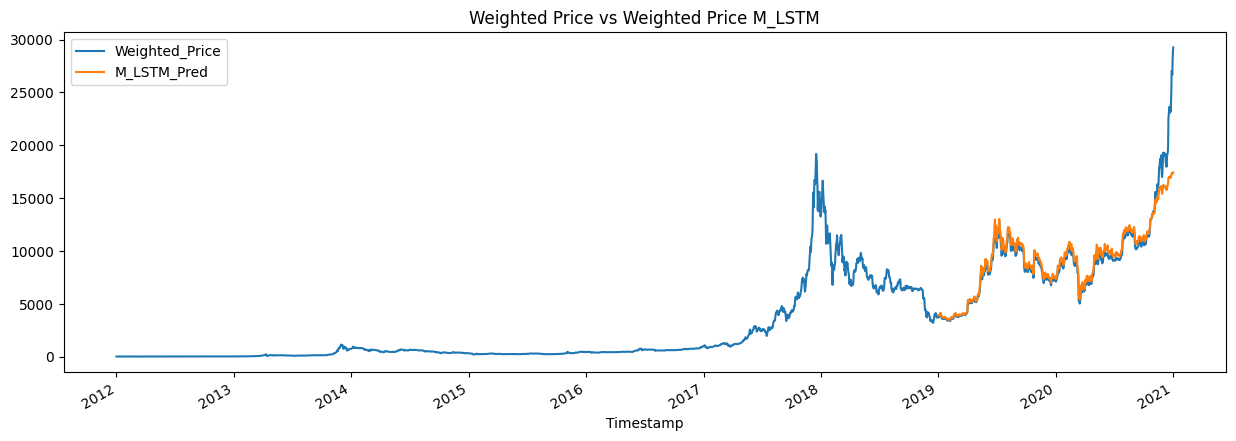

In [59]:
mixed_data[['Weighted_Price','M_LSTM_Pred']].plot(figsize=(15, 5),title=('Weighted Price vs Weighted Price M_LSTM'))

In [60]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math 
from sklearn.metrics import mean_absolute_error

In [61]:
rmse=math.sqrt(mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['M_LSTM_Pred']))
print('RMSE:',rmse)

RMSE: 1385.6991393090336


In [62]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['M_LSTM_Pred'])

622.4471559258669

In [63]:
r2_score(data_test['Weighted_Price'], data_test['M_LSTM_Pred'])

0.8832888627210169

# -------------------------------------------------------------------------------------

## <font color= blue >7.2 Univariate Time Series with LSTM </font> <a class="anchor" id="fifth-bullet"></a>

Preparing the data to train and validate the the Univariate Time Series Model

In [64]:
only_train=train.to_numpy()
only_test=test.to_numpy()

In [65]:
only_train1=only_train[0:len(only_train)-1]
only_test1=only_test[0:len(only_test)-1]

only_y_train=only_train[1:len(only_train)]
only_y_test=only_test[1:len(only_test)]

In [66]:
len(only_train1)

2557

In [67]:
print(only_train1.shape, only_y_train.shape, only_test1.shape, only_y_test.shape)

(2557, 1) (2557, 1) (730, 1) (730, 1)


In [68]:
len(only_train[1:len(only_train)])

2557

In [69]:
only_train1 = only_train1.reshape((only_train1.shape[0], 1, only_train1.shape[1]))
only_test1 = only_test1.reshape((only_test1.shape[0], 1, only_test1.shape[1]))
print(only_train1.shape, only_y_train.shape, only_test1.shape, only_y_test.shape)

(2557, 1, 1) (2557, 1) (730, 1, 1) (730, 1)


In [70]:
only_train.shape

(2558, 1)

In [71]:
only_y_train=only_y_train.reshape((only_y_train.shape[0],only_y_train.shape[1]))

In [72]:
only_y_test = only_y_test.reshape((only_y_test.shape[0], only_y_test.shape[1]))

In [73]:
print(only_train1.shape, only_y_train.shape)

(2557, 1, 1) (2557, 1)


In [74]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


uni_model = Sequential()
uni_model.add(LSTM(120,activation="sigmoid",input_shape=(1,1)))
uni_model.add(Dropout(0.2))
uni_model.add(Dense(1))
uni_model.compile(loss='mean_squared_error', optimizer='adam')  
history1=uni_model.fit(only_train1, only_y_train, epochs=100, batch_size=50, verbose=2, validation_data=(only_test1, only_y_test), shuffle=False)#

Epoch 1/100
52/52 - 3s - loss: 0.7115 - val_loss: 3.0937 - 3s/epoch - 53ms/step
Epoch 2/100
52/52 - 1s - loss: 0.5358 - val_loss: 2.5561 - 1s/epoch - 23ms/step
Epoch 3/100
52/52 - 1s - loss: 0.5028 - val_loss: 2.2998 - 1s/epoch - 23ms/step
Epoch 4/100
52/52 - 1s - loss: 0.4523 - val_loss: 2.0278 - 1s/epoch - 22ms/step
Epoch 5/100
52/52 - 1s - loss: 0.4183 - val_loss: 1.7801 - 1s/epoch - 22ms/step
Epoch 6/100
52/52 - 1s - loss: 0.3696 - val_loss: 1.5480 - 1s/epoch - 23ms/step
Epoch 7/100
52/52 - 1s - loss: 0.3262 - val_loss: 1.3221 - 1s/epoch - 24ms/step
Epoch 8/100
52/52 - 1s - loss: 0.2876 - val_loss: 1.1294 - 1s/epoch - 22ms/step
Epoch 9/100
52/52 - 1s - loss: 0.2480 - val_loss: 0.9426 - 1s/epoch - 22ms/step
Epoch 10/100
52/52 - 1s - loss: 0.2124 - val_loss: 0.7783 - 1s/epoch - 22ms/step
Epoch 11/100
52/52 - 1s - loss: 0.1786 - val_loss: 0.6165 - 1s/epoch - 22ms/step
Epoch 12/100
52/52 - 1s - loss: 0.1573 - val_loss: 0.4980 - 1s/epoch - 22ms/step
Epoch 13/100
52/52 - 1s - loss: 0.129

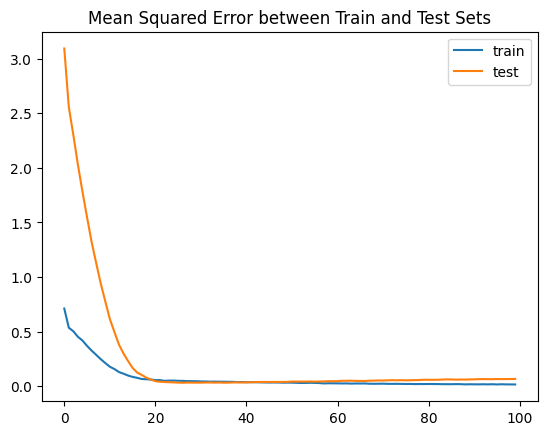

In [75]:
import matplotlib.pyplot as pyplot 
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Mean Squared Error between Train and Test Sets')
pyplot.show()

In [76]:
uni_predicted_BTC_price = uni_model.predict(only_test.reshape(only_test.shape[0],1,1))
uni_predicted_BTC_price

23/23 [==============================] - 0s 6ms/step


array([[0.11517736],
       [0.11971469],
       [0.10791798],
       [0.11939687],
       [0.12410416],
       [0.1603645 ],
       [0.15666828],
       [0.1572154 ],
       [0.11636157],
       [0.07604589],
       [0.07397029],
       [0.06539705],
       [0.06202139],
       [0.0781751 ],
       [0.06853473],
       [0.06837302],
       [0.0718447 ],
       [0.08212923],
       [0.0719036 ],
       [0.05472489],
       [0.05725144],
       [0.06192289],
       [0.05801892],
       [0.05897583],
       [0.06216912],
       [0.05687459],
       [0.03443766],
       [0.02519926],
       [0.02949109],
       [0.03095926],
       [0.02837744],
       [0.03199225],
       [0.03112186],
       [0.02802374],
       [0.0290901 ],
       [0.02028332],
       [0.01809921],
       [0.0338181 ],
       [0.07133406],
       [0.06988902],
       [0.06787536],
       [0.06354158],
       [0.06443252],
       [0.06169181],
       [0.0617073 ],
       [0.0653649 ],
       [0.06439953],
       [0.098

In [77]:
X_test.shape

(731, 6)

In [78]:
data_test['M_LSTM_Pred'] = Bitcoin_pred
mixed_data = pd.concat([data_test, data_train], sort=False)

In [79]:
Bitcoin_pred_uni = concatenate((uni_predicted_BTC_price, X_test), axis=1)
Bitcoin_pred_uni = scaler.inverse_transform(Bitcoin_pred_uni)
Bitcoin_pred_uni[:,0]

array([ 4029.05384127,  4049.77718597,  3995.89805508,  4048.32557521,
        4069.82519035,  4235.43703869,  4218.5553003 ,  4221.05418878,
        4034.46248485,  3850.32863037,  3840.84875252,  3801.69221747,
        3786.27454447,  3860.05338119,  3816.02293488,  3815.28436861,
        3831.14053981,  3878.1130688 ,  3831.40957339,  3752.94922561,
        3764.4887451 ,  3785.82468057,  3767.99407645,  3772.3645621 ,
        3786.94927227,  3762.76755629,  3660.2913841 ,  3618.09680448,
        3637.69889233,  3644.40445066,  3632.61253778,  3649.12244085,
        3645.14713444,  3630.99707719,  3635.86744943,  3595.64424011,
        3585.66876333,  3657.46166531,  3828.80832556,  3822.20839337,
        3813.0113649 ,  3793.21769355,  3797.28688608,  3784.76923589,
        3784.84001629,  3801.54534813,  3797.1362055 ,  3951.76613418,
        4110.03077263,  4122.43796456,  4121.96795547,  4134.15770185,
        4182.56469096,  4226.20890767,  4000.52614056,  4014.00810567,
      

In [80]:
data_test['Uni_LSTM_Pred']=Bitcoin_pred_uni[:,0]
data_test.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,M_LSTM_Pred,Uni_LSTM_Pred
Timestamp,,,,,,,,,
2019-01-02,3815.927500,3818.779583,3815.099583,3817.929167,4.840742,18622.726238,3816.618072,3914.745874,4029.053841
2019-01-03,3837.342083,3838.425417,3836.031667,3837.857083,1.902776,7328.448351,3837.468446,3911.220466,4049.777186
2019-01-04,3782.768333,3785.064167,3781.533333,3783.452917,4.809525,18203.907485,3783.228856,3881.220260,3995.898055
2019-01-05,3835.461250,3836.792083,3834.657083,3836.129167,3.316241,12718.473391,3836.008899,3920.629223,4048.325575
2019-01-06,3855.950417,3859.148333,3855.473750,3858.436250,2.775965,10939.781885,3857.625335,3937.958103,4069.825190


In [81]:
mixed_data2 = pd.concat([data_test, data_train], sort=False)
mixed_data2.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,M_LSTM_Pred,Uni_LSTM_Pred
Timestamp,,,,,,,,,
2019-01-02,3815.927500,3818.779583,3815.099583,3817.929167,4.840742,18622.726238,3816.618072,3914.745874,4029.053841
2019-01-03,3837.342083,3838.425417,3836.031667,3837.857083,1.902776,7328.448351,3837.468446,3911.220466,4049.777186
2019-01-04,3782.768333,3785.064167,3781.533333,3783.452917,4.809525,18203.907485,3783.228856,3881.220260,3995.898055
2019-01-05,3835.461250,3836.792083,3834.657083,3836.129167,3.316241,12718.473391,3836.008899,3920.629223,4048.325575
2019-01-06,3855.950417,3859.148333,3855.473750,3858.436250,2.775965,10939.781885,3857.625335,3937.958103,4069.825190


<AxesSubplot: title={'center': 'Actual Weighted Price vs Weighted Price U_LSTM'}, xlabel='Timestamp'>

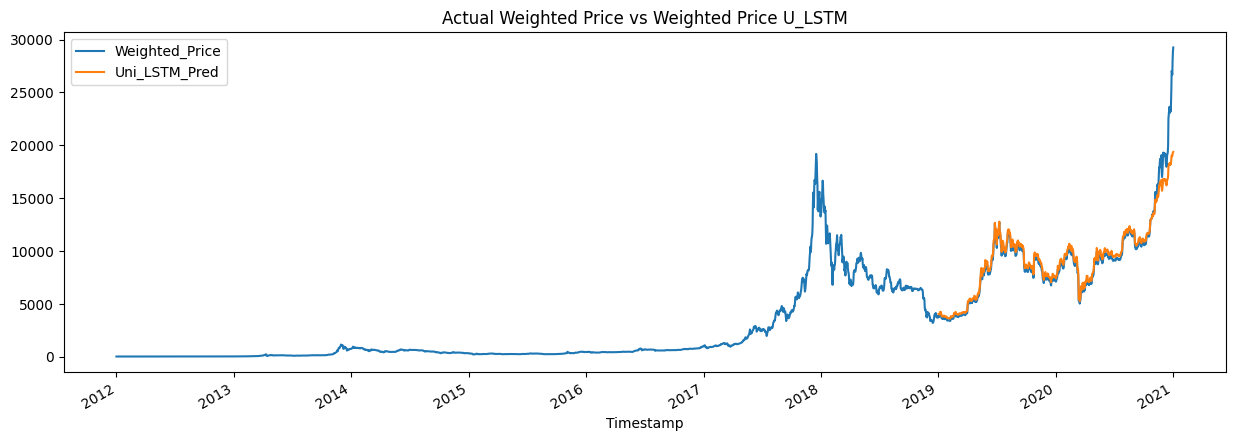

In [82]:
mixed_data2[['Weighted_Price','Uni_LSTM_Pred']].plot(figsize=(15, 5),title=('Actual Weighted Price vs Weighted Price U_LSTM'))

In [83]:
mixed_data2=mixed_data2.reset_index()

In [84]:
final_data['Uni_LSTM_Pred']=mixed_data2['Uni_LSTM_Pred']
final_data

,Timestamp,Weighted_Price,LSTM prediction,Uni_LSTM_Pred
0,2019-01-02,3816.618072,3914.745874,4029.053841
1,2019-01-03,3837.468446,3911.220466,4049.777186
2,2019-01-04,3783.228856,3881.220260,3995.898055
3,2019-01-05,3836.008899,3920.629223,4048.325575
4,2019-01-06,3857.625335,3937.958103,4069.825190
...,...,...,...,...
3284,2018-12-28,3683.368969,NaN,NaN
3285,2018-12-29,3874.444404,NaN,NaN
3286,2018-12-30,3791.141409,NaN,NaN
3287,2018-12-31,3768.529517,NaN,NaN


In [85]:
rmse=math.sqrt(mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Uni_LSTM_Pred']))
print('RMSE:',rmse)

RMSE: 1130.1937063972177


In [86]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Uni_LSTM_Pred'])

515.6021206969235

In [87]:
r2_score(data_test['Weighted_Price'], data_test['Uni_LSTM_Pred'])

0.9223609566111362

# -------------------------------------------------------------------------------------

## <font color= blue >7.3 Time Series Forecasting with FacebookProphet </font> <a class="anchor" id="fifth-bullet"></a>

__Prophet__ is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. <br>

It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. <br>


__Data does not need to be normalized, Prophet will actually internally scale y before fitting the model__<br>

In [88]:
# In anaconda prompt
# conda install libpython m2w64-toolchain -c msys2
# pip install pystan
# pip install fbprophet

In [89]:
df_day.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2012-01-01,4.747500,4.747500,4.747500,4.747500,3.912366,19.604574,4.747500
2012-01-02,5.002667,5.002667,5.002667,5.002667,14.035180,69.592551,5.002667
2012-01-03,5.205212,5.205212,5.205212,5.205212,9.853269,51.408023,5.205212
2012-01-04,5.181548,5.216340,5.181548,5.216340,16.580542,89.792815,5.194110
2012-01-05,6.119948,6.127240,6.119948,6.127240,4.859769,27.799823,6.123903


In [90]:
#Facebook Prophet packages:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric


from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
# Warnings
import warnings
warnings.filterwarnings('ignore')

In [91]:
# Renaming the column names accroding to Prophet's requirements
prophet_df = df_day.reset_index()[['Timestamp','Weighted_Price']]
prophet_df.rename(columns={'Timestamp':'ds','Weighted_Price':'y'},inplace=True)

In [92]:
# Basic model 
prophet_basic = Prophet()
prophet_basic.fit(prophet_df[['ds','y']])

21:03:11 - cmdstanpy - INFO - Chain [1] start processing
21:03:13 - cmdstanpy - INFO - Chain [1] done processing


In [93]:
# Making predictions for 1 year, until 2022-01-01
future= prophet_basic.make_future_dataframe(periods=365)#Making predictions for one year
future.tail(1)

,ds
3653,2022-01-01


In [94]:
forecast = prophet_basic.predict(future)

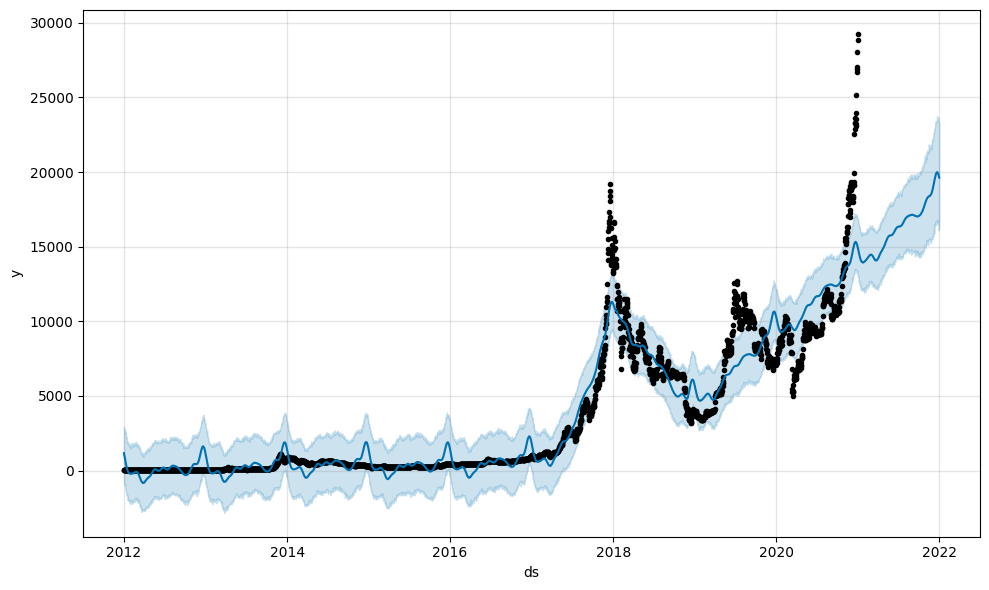

In [95]:
fig = prophet_basic.plot(forecast)

__Adding ChangePoints to Prophet__<br>
Changepoints are the datetime points where the time series have abrupt changes in the trajectory.<br>
By default, Prophet adds 25 changepoints to the initial 80% of the data-set.

Change points:  {prophet_basic.changepoints}



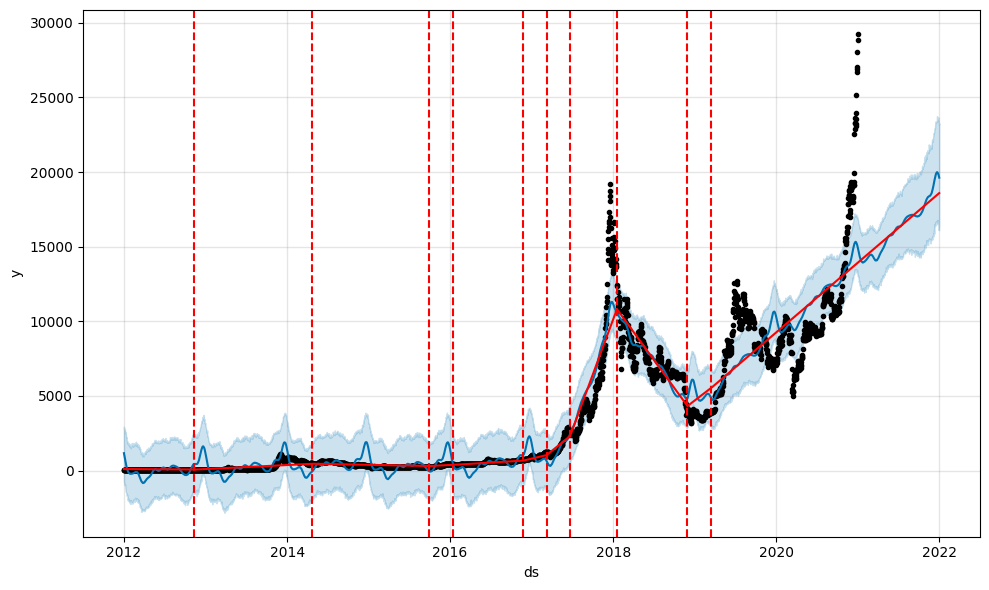

In [96]:
fig_1 = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig_1.gca(), prophet_basic, forecast)

print('Change points: ','{prophet_basic.changepoints}\n')

In [97]:
print('Change points:\n\n',prophet_basic.changepoints)

Change points:

 105    2012-04-15
210    2012-07-29
316    2012-11-12
421    2013-02-25
526    2013-06-10
631    2013-09-23
736    2014-01-06
842    2014-04-22
947    2014-08-05
1052   2014-11-18
1157   2015-03-03
1262   2015-06-16
1368   2015-09-30
1473   2016-01-13
1578   2016-04-27
1683   2016-08-10
1788   2016-11-23
1894   2017-03-09
1999   2017-06-22
2104   2017-10-05
2209   2018-01-18
2314   2018-05-03
2420   2018-08-17
2525   2018-11-30
2630   2019-03-15
Name: ds, dtype: datetime64[ns]


__Adding Multiple Regressors__ <br>
Additional regressors can be added to the Prophet model. This is done by using add_regressor. <br>
Additional regressor column value needs to be present in both the fitting as well as prediction dataframes.


In [98]:
prophet_df['Open'] = df_day.reset_index()['Open']
prophet_df['High'] = df_day.reset_index()['High']
prophet_df['Low'] = df_day.reset_index()['Low']
prophet_df['Vol(BTC)'] = df_day.reset_index()['Volume_(BTC)']
prophet_df['Vol(curr)'] = df_day.reset_index()['Volume_(Currency)']

In [99]:
prophet_df.head()

,ds,y,Open,High,Low,Vol(BTC),Vol(curr)
0,2012-01-01,4.747500,4.747500,4.747500,4.747500,3.912366,19.604574
1,2012-01-02,5.002667,5.002667,5.002667,5.002667,14.035180,69.592551
2,2012-01-03,5.205212,5.205212,5.205212,5.205212,9.853269,51.408023
3,2012-01-04,5.194110,5.181548,5.216340,5.181548,16.580542,89.792815
4,2012-01-05,6.123903,6.119948,6.127240,6.119948,4.859769,27.799823


In [100]:
pro_regressor= Prophet()
pro_regressor.add_regressor('Open')
pro_regressor.add_regressor('High')
pro_regressor.add_regressor('Low')
pro_regressor.add_regressor('Vol(BTC)')
pro_regressor.add_regressor('Vol(curr)')

splitter= '2019-01-01'
train_X = prophet_df.loc[prophet_df.ds <= splitter]
test_X = prophet_df.loc[prophet_df.ds > splitter]

In [101]:
#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=365)

21:03:15 - cmdstanpy - INFO - Chain [1] start processing
21:03:21 - cmdstanpy - INFO - Chain [1] done processing


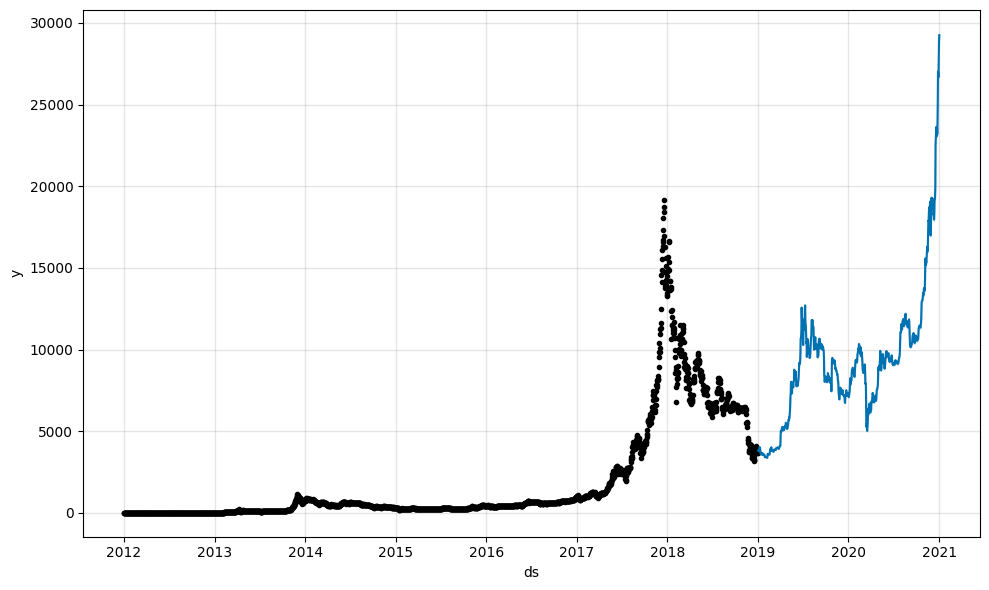

In [102]:
#Forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data);

In [103]:
df_cv = cross_validation(pro_regressor, initial='100 days', period='180 days', horizon = '365 days')
pm = performance_metrics(df_cv, rolling_window=0.1)
display(pm.head(),pm.tail())

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|                                                                                           | 0/12 [00:00<?, ?it/s]21:03:22 - cmdstanpy - INFO - Chain [1] start processing
21:03:22 - cmdstanpy - INFO - Chain [1] done processing
  8%|██████▉                                                                            | 1/12 [00:01<00:12,  1.09s/it]21:03:23 - cmdstanpy - INFO - Chain [1] start processing
21:03:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█████████████▊                                                                     | 2/12 [00:02<00:10,  1.05s/it]21:03:24 - cmdstanpy - INFO - Chain [1] start processing
21:03:25 - cmdstanpy - INFO - Chain [1] done processing
 25%|████████████████████▊                                                              | 3/12 [00:03<00:10,  1.14s/it]21:03:25 - cmdstanpy - INFO - Chain [1] start processing
21:03:27 - cmdstanpy - I

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.677290,0.822976,0.304796,0.002351,0.000186,0.002278,0.757991
1,38 days,0.676223,0.822328,0.308748,0.002645,0.000196,0.002556,0.743151
2,39 days,0.660531,0.812731,0.314052,0.002974,0.000207,0.002865,0.729452
3,40 days,0.606204,0.778591,0.310357,0.003325,0.000218,0.003192,0.719178
4,41 days,0.572494,0.756634,0.311025,0.003708,0.000230,0.003546,0.710046


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
324,361 days,7.891031,2.809098,2.012003,0.007256,0.001049,0.007097,0.757991
325,362 days,7.894932,2.809792,2.011871,0.007284,0.000976,0.007124,0.760274
326,363 days,7.901874,2.811027,2.015883,0.007308,0.001117,0.007147,0.761416
327,364 days,7.887611,2.808489,2.018948,0.007329,0.001117,0.007167,0.761416
328,365 days,7.863572,2.804206,2.014819,0.007338,0.001117,0.007176,0.763699


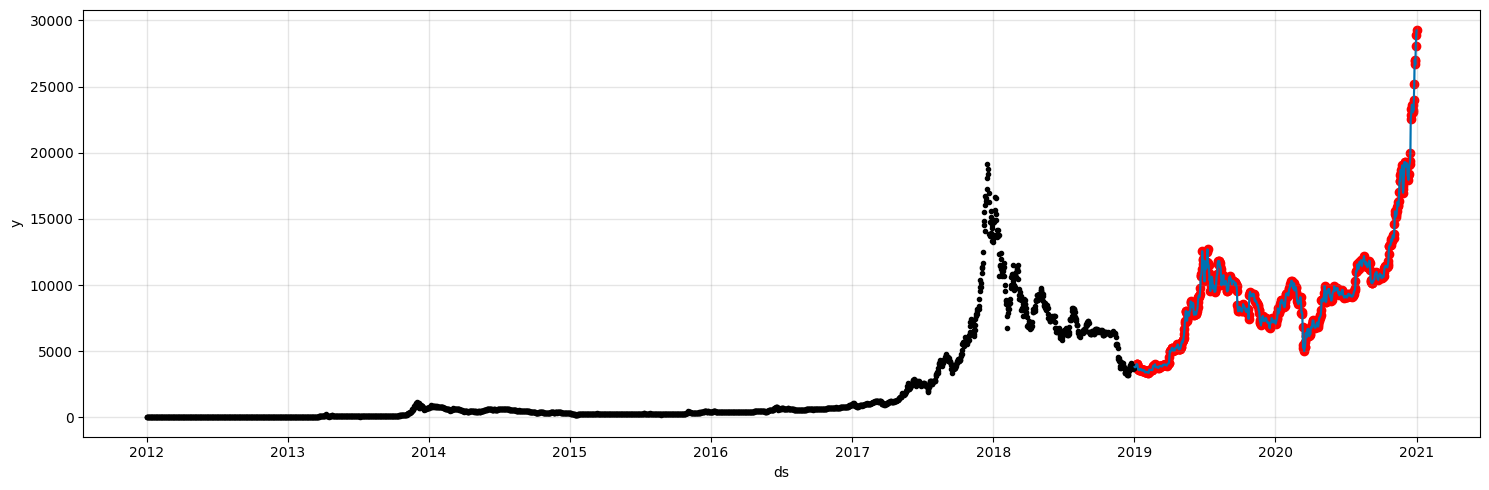

In [104]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test_X.ds, test_X.y, color='r')
fig = pro_regressor.plot(forecast_data, ax=ax)

In [106]:
 from prophet.utilities import regressor_coefficients

In [107]:
regressor_coefficients(pro_regressor)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Open,additive,1861.113559,0.016692,0.016692,0.016692
1,High,additive,1862.778111,0.469559,0.469559,0.469559
2,Low,additive,1859.337649,0.513597,0.513597,0.513597
3,Vol(BTC),additive,13.480481,0.000196,0.000196,0.000196
4,Vol(curr),additive,18090.637587,-0.000001,-0.000001,-0.000001


In [108]:
#for comparision of predictions
forecast_data = forecast_data.rename(columns={'ds': 'Timestamp'})
forecast_data = forecast_data.rename(columns={'yhat': 'prophet'})
test_X = test_X.rename(columns={'ds': 'Timestamp'})
test_X = test_X.rename(columns={'y': 'Weighted_Price'})

data_compare = pd.merge(test_X, forecast_data, on='Timestamp')
data_compare = data_compare[['Timestamp','Weighted_Price','prophet']]
data_compare = data_compare.set_index('Timestamp')
data_compare.head()

,Weighted_Price,prophet
Timestamp,,
2019-01-02,3816.618072,3817.503010
2019-01-03,3837.468446,3837.813683
2019-01-04,3783.228856,3783.858755
2019-01-05,3836.008899,3836.338979
2019-01-06,3857.625335,3857.886705


In [135]:
data_compare.tail()

,Weighted_Price,prophet
Timestamp,,
2020-12-28,26916.051799,26910.533924
2020-12-29,26677.496538,26672.251891
2020-12-30,28045.991058,28036.486642
2020-12-31,28870.443943,28863.901647
2021-01-01,29253.240604,29245.191338


In [109]:
rmse=math.sqrt(mean_squared_error(y_true=data_compare['Weighted_Price'],
                   y_pred=data_compare['prophet']))
print('RMSE:',rmse)

RMSE: 2.8695619263033487


In [110]:
mean_absolute_error(y_true=data_compare['Weighted_Price'],
                   y_pred=data_compare['prophet'])

2.342032013153318

In [111]:
r2_score(data_compare['Weighted_Price'], data_compare['prophet'])

0.9999994994982395

# -------------------------------------------------------------------------------------

## <font color= blue >7.4 Time Series Forecasting with ARIMAX </font> <a class="anchor" id="fifth-bullet"></a>

__pmdarima package: project description__ https://pypi.org/project/pmdarima/#description

For this model we will be using Auto ARIMA functionality in python using the pmdarima package. <br>

In Auto ARIMA function itself operates a bit like a grid search. The model itself will generate the optimal p, d, and q parameters which would be best suitable for the data set to provide better forecasting.

In [112]:
import pmdarima as pm

In [113]:
df_1 = df_day.copy()

In [114]:
# basically creating a range that includes all data
start = '2012-01-01'
end = '2021-01-01'

# find rows between start and end time 
df_1 = df_1[(df_1.index >= start) & (df_1.index <= end)]
df_1.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2020-12-28,26905.933333,26945.005417,26888.671250,26919.222917,6.567626,177385.948307,26916.051799
2020-12-29,26676.817083,26699.222500,26656.897917,26678.315417,7.864092,209316.129563,26677.496538
2020-12-30,28038.661250,28072.815000,28013.447500,28048.821667,13.446045,379456.368365,28045.991058
2020-12-31,28871.430833,28896.700000,28843.775000,28871.962917,6.531982,188046.715438,28870.443943
2021-01-01,29255.712917,29276.903750,29226.102917,29248.485833,7.157206,209315.586386,29253.240604


In [115]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3289 entries, 2012-01-01 to 2021-01-01
Freq: D
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               3289 non-null   float64
 1   High               3289 non-null   float64
 2   Low                3289 non-null   float64
 3   Close              3289 non-null   float64
 4   Volume_(BTC)       3289 non-null   float64
 5   Volume_(Currency)  3289 non-null   float64
 6   Weighted_Price     3289 non-null   float64
dtypes: float64(7)
memory usage: 205.6 KB


In [116]:
exogenous_features = ['Open','High','Low','Close','Volume_(BTC)','Volume_(Currency)']

In [136]:
model = pm.auto_arima(data_train.Weighted_Price, exogenous=data_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(data_train.Weighted_Price, exogenous=data_train[exogenous_features])

forecast = model.predict(n_periods=len(data_test), exogenous=data_test[exogenous_features])
data_test["ARIMAX_Pred"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=33434.030, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33566.998, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33462.361, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=33472.314, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33565.179, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=33432.694, Time=1.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=33458.653, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=33463.505, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=33434.141, Time=2.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=33457.381, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33435.000, Time=1.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=33434.144, Time=3.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=33430.786, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=33456.762, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0

In [137]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2558
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -16711.393
Date:                Wed, 12 Oct 2022   AIC                          33430.786
Time:                        21:27:25   BIC                          33454.172
Sample:                    01-01-2012   HQIC                         33439.267
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9094      0.008   -113.026      0.000      -0.925      -0.894
ma.L1          1.1172      0.009    126.025      0.000       1.100       1.135
ma.L2          0.2339      0.005     45.655      0.000       0.224       0.244
sigma2      2.781e+04    160.535    173.236      0.000    2.75e+04    2.81e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            233233.36
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):             225.98   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [138]:
mixed_data3 = pd.concat([data_test, data_train], sort=False)
mixed_data3.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,M_LSTM_Pred,Uni_LSTM_Pred,ARIMAX_Pred
Timestamp,,,,,,,,,,
2019-01-02,3815.927500,3818.779583,3815.099583,3817.929167,4.840742,18622.726238,3816.618072,3914.745874,4029.053841,3686.661414
2019-01-03,3837.342083,3838.425417,3836.031667,3837.857083,1.902776,7328.448351,3837.468446,3911.220466,4049.777186,3677.736396
2019-01-04,3782.768333,3785.064167,3781.533333,3783.452917,4.809525,18203.907485,3783.228856,3881.220260,3995.898055,3685.852941
2019-01-05,3835.461250,3836.792083,3834.657083,3836.129167,3.316241,12718.473391,3836.008899,3920.629223,4048.325575,3678.471633
2019-01-06,3855.950417,3859.148333,3855.473750,3858.436250,2.775965,10939.781885,3857.625335,3937.958103,4069.825190,3685.184304


<AxesSubplot: title={'center': 'Actual Weighted Price vs ARIMAX Price Prediction'}, xlabel='Timestamp'>

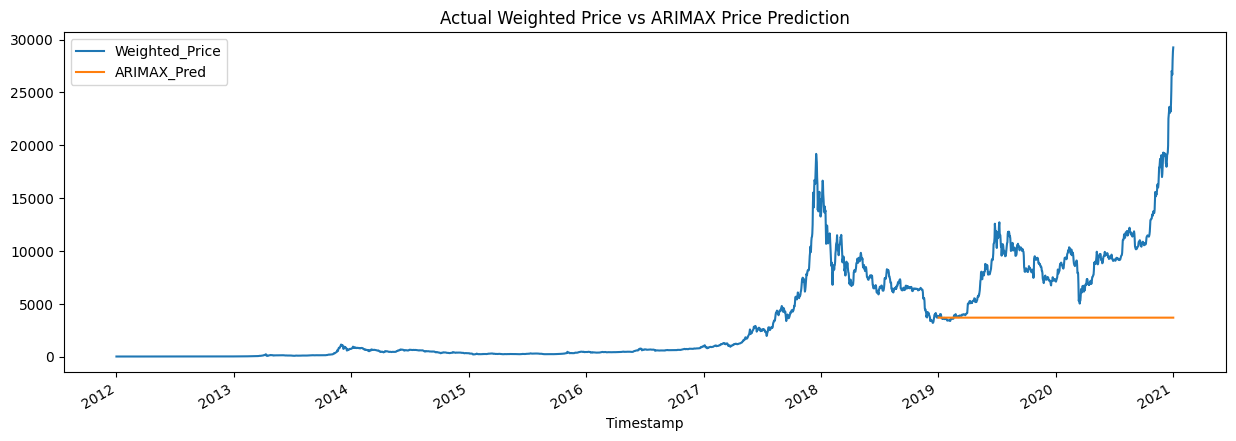

In [139]:
mixed_data3[['Weighted_Price','ARIMAX_Pred']].plot(figsize=(15, 5),title=('Actual Weighted Price vs ARIMAX Price Prediction'))

Text(0.5, 1.0, 'Weighted Price vs Arimax Prediction')

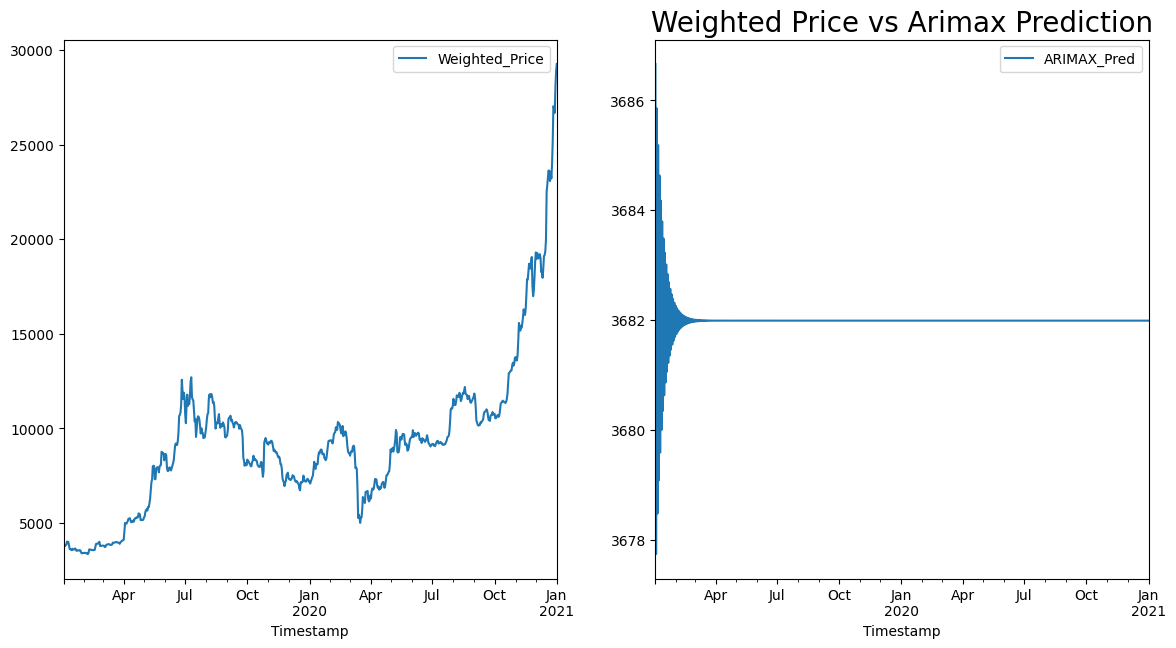

In [140]:
# For Monthly Frequency ACF and PACF

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

data_test[["Weighted_Price"]].plot(figsize=(14, 7), ax=ax1)

data_test[["ARIMAX_Pred"]].plot(figsize=(14, 7), ax=ax2)
plt.title("Weighted Price vs Arimax Prediction", size=20)


In [122]:
rmse=math.sqrt(mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['ARIMAX_Pred']))
print('RMSE:',rmse)

RMSE: 6887.776528366274


In [123]:

mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['ARIMAX_Pred'])

5582.09376492423

In [124]:
r2_score(data_test['Weighted_Price'], data_test['ARIMAX_Pred'])

-1.8835833077511484

# -------------------------------------------------------------------------------------

## <font color= blue >8. Results comparison </font> <a class="anchor" id="fifth-bullet"></a>

In [125]:
mixed_data3['Prophet_Pred'] = data_compare['prophet']
final_comp = mixed_data3.copy()
display(final_comp.head())

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,M_LSTM_Pred,Uni_LSTM_Pred,ARIMAX_Pred,Prophet_Pred
Timestamp,,,,,,,,,,,
2019-01-02,3815.927500,3818.779583,3815.099583,3817.929167,4.840742,18622.726238,3816.618072,3914.745874,4029.053841,3686.661414,3817.503010
2019-01-03,3837.342083,3838.425417,3836.031667,3837.857083,1.902776,7328.448351,3837.468446,3911.220466,4049.777186,3677.736396,3837.813683
2019-01-04,3782.768333,3785.064167,3781.533333,3783.452917,4.809525,18203.907485,3783.228856,3881.220260,3995.898055,3685.852941,3783.858755
2019-01-05,3835.461250,3836.792083,3834.657083,3836.129167,3.316241,12718.473391,3836.008899,3920.629223,4048.325575,3678.471633,3836.338979
2019-01-06,3855.950417,3859.148333,3855.473750,3858.436250,2.775965,10939.781885,3857.625335,3937.958103,4069.825190,3685.184304,3857.886705


In [126]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.Weighted_Price, name='Weighted_Price',
                         line=dict(color='chartreuse', width=4)))
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.M_LSTM_Pred, name = 'M_LSTM_Pred',
                         line=dict(color='coral', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.Uni_LSTM_Pred, name='Uni_LSTM_Pred',
                         line=dict(color='crimson', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.ARIMAX_Pred, name='ARIMAX_Pred',
                         line = dict(color='cyan', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=final_comp.index, y=final_comp.Prophet_Pred, name='Prophet_Pred',
                         line=dict(color='darkblue', width=4, dash='dot')))
fig.update_layout(title='Models Comparison',
                   xaxis_title='Years',
                   yaxis_title='USD (thousands)')
fig.show()

In [127]:
# split data into train and test sets
splitter= '2019-01-01'
df_results = final_comp[['Weighted_Price','M_LSTM_Pred','Uni_LSTM_Pred','ARIMAX_Pred','Prophet_Pred']]
df_results = df_results.loc[df_results.index > splitter]

display(df_results.head())


# Plot 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.Weighted_Price, name='Weighted_Price',
                         line=dict(color='chartreuse', width=4)))
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.M_LSTM_Pred, name = 'M_LSTM_Pred',
                         line=dict(color='coral', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.Uni_LSTM_Pred, name='Uni_LSTM_Pred',
                         line=dict(color='crimson', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.ARIMAX_Pred, name='ARIMAX_Pred',
                         line = dict(color='yellow', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=df_results.index, y=df_results.Prophet_Pred, name='Prophet_Pred',
                         line=dict(color='darkblue', width=4, dash='dot')))
fig.update_layout(title='Models Comparison',
                   xaxis_title='Years',
                   yaxis_title='USD (thousands)')
fig.show()

,Weighted_Price,M_LSTM_Pred,Uni_LSTM_Pred,ARIMAX_Pred,Prophet_Pred
Timestamp,,,,,
2019-01-02,3816.618072,3914.745874,4029.053841,3686.661414,3817.503010
2019-01-03,3837.468446,3911.220466,4049.777186,3677.736396,3837.813683
2019-01-04,3783.228856,3881.220260,3995.898055,3685.852941,3783.858755
2019-01-05,3836.008899,3920.629223,4048.325575,3678.471633,3836.338979
2019-01-06,3857.625335,3937.958103,4069.825190,3685.184304,3857.886705


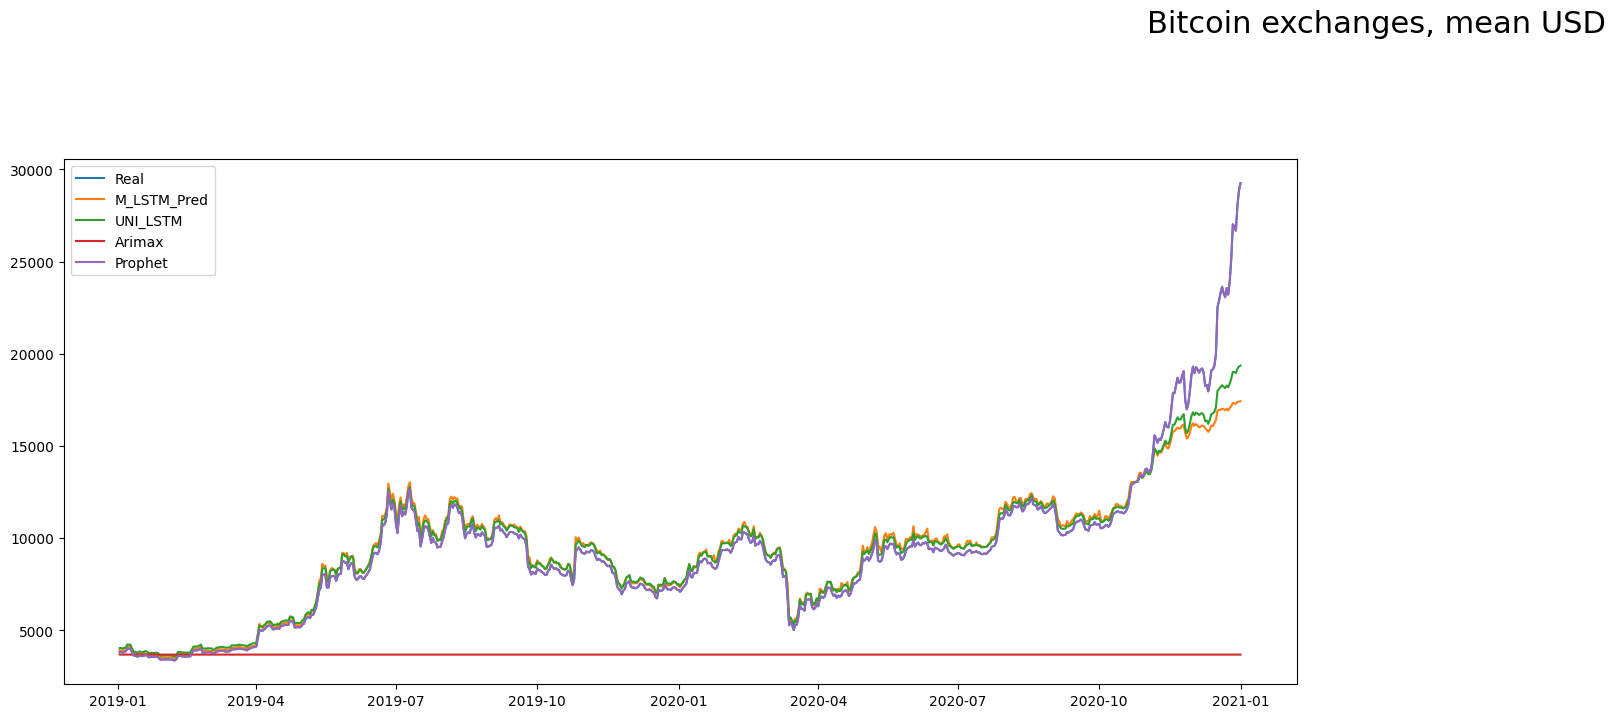

In [128]:
# PLOTS
fig = plt.figure(figsize=[35, 15])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df_results.Weighted_Price, '-', label='Real')
plt.legend()
plt.subplot(221)
plt.plot(df_results.M_LSTM_Pred, '-', label='M_LSTM_Pred')
plt.legend()
plt.subplot(221)
plt.plot(df_results.Uni_LSTM_Pred, '-', label='UNI_LSTM')
plt.legend()
plt.subplot(221)
plt.plot(df_results.ARIMAX_Pred, '-', label='Arimax')
plt.legend()
plt.subplot(221)
plt.plot(df_results.Prophet_Pred, '-', label='Prophet')
plt.legend()
plt.show()

In [129]:
df_results

,Weighted_Price,M_LSTM_Pred,Uni_LSTM_Pred,ARIMAX_Pred,Prophet_Pred
Timestamp,,,,,
2019-01-02,3816.618072,3914.745874,4029.053841,3686.661414,3817.503010
2019-01-03,3837.468446,3911.220466,4049.777186,3677.736396,3837.813683
2019-01-04,3783.228856,3881.220260,3995.898055,3685.852941,3783.858755
2019-01-05,3836.008899,3920.629223,4048.325575,3678.471633,3836.338979
2019-01-06,3857.625335,3937.958103,4069.825190,3685.184304,3857.886705
...,...,...,...,...,...
2020-12-28,26916.051799,17298.557562,19002.870149,3681.987198,26910.533924
2020-12-29,26677.496538,17291.638506,18960.213523,3681.987198,26672.251891
2020-12-30,28045.991059,17396.363010,19189.006272,3681.987198,28036.486642


In [130]:
print('RMSE:',math.sqrt(mean_squared_error(y_true=df_results['Weighted_Price'],y_pred=df_results['M_LSTM_Pred'])))
print('MAE:', mean_absolute_error(y_true=df_results['Weighted_Price'],y_pred=df_results['M_LSTM_Pred']))
print('R2_score:', r2_score(df_results['Weighted_Price'], df_results['M_LSTM_Pred']))

RMSE: 1385.6991393090336
MAE: 622.4471559258669
R2_score: 0.8832888627210169


In [131]:
print('RMSE:',math.sqrt(mean_squared_error(y_true=df_results['Weighted_Price'],y_pred=df_results['Uni_LSTM_Pred'])))
print('MAE:', mean_absolute_error(y_true=df_results['Weighted_Price'],y_pred=df_results['Uni_LSTM_Pred']))
print('R2_score:', r2_score(df_results['Weighted_Price'], df_results['Uni_LSTM_Pred']))

RMSE: 1130.1937063972177
MAE: 515.6021206969235
R2_score: 0.9223609566111362


In [132]:
print('RMSE:',math.sqrt(mean_squared_error(y_true=df_results['Weighted_Price'],y_pred=df_results['ARIMAX_Pred'])))
print('MAE:', mean_absolute_error(y_true=df_results['Weighted_Price'],y_pred=df_results['ARIMAX_Pred']))
print('R2_score:', r2_score(df_results['Weighted_Price'], df_results['ARIMAX_Pred']))

RMSE: 6887.776528366274
MAE: 5582.09376492423
R2_score: -1.8835833077511484


In [133]:
print('RMSE:',math.sqrt(mean_squared_error(y_true=df_results['Weighted_Price'],y_pred=df_results['Prophet_Pred'])))
print('MAE:', mean_absolute_error(y_true=df_results['Weighted_Price'],y_pred=df_results['Prophet_Pred']))
print('R2_score:', r2_score(df_results['Weighted_Price'], df_results['Prophet_Pred']))

RMSE: 2.86956192630336
MAE: 2.342032013153322
R2_score: 0.9999994994982395
